# 🎬 Movie Recommendation System (User & Item-Based Collaborative Filtering)

> This project develops a Movie Recommendation System using the MovieLens dataset.
- It implements two collaborative filtering techniques:

> User-Based Collaborative Filtering – recommends movies to a user based on ratings from similar users.

> Item-Based Collaborative Filtering – recommends movies based on similarity between items (movies) the user has already rated.

> The system also includes data visualization, evaluation using Precision@K, and an interactive demo.

In [42]:
# ============================================================
# 0. Import Required Libraries
# ============================================================
# Numpy & Pandas: Data manipulation
# Sklearn: Cosine similarity & train-test split
# KaggleHub: Access to MovieLens dataset
# Matplotlib & Seaborn: Visualization

import numpy as np
import pandas as pd
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import train_test_split
import kagglehub
from kagglehub import KaggleDatasetAdapter
import matplotlib.pyplot as plt
import seaborn as sns


## 1. Dataset Loading

> Objective: Import movie, rating, and user demographic information from KaggleHub.

> The dataset includes three files:

- movie_info.csv → Movie titles, genres, and IDs.

- ratings.csv → User ratings for movies.

- user_demographics.csv → Age, gender, and other attributes of users.

> We also ensure consistent column naming (movie_id).

In [43]:
# ============================================================
# 1. Load datasets from KaggleHub
# ============================================================
print("--- Loading datasets ---")
try:
    movie_info_df = kagglehub.load_dataset(
        KaggleDatasetAdapter.PANDAS,
        "mukeshmanral/movielens-rating-dataset",
        "movie_info.csv",
    )
    rating_df = kagglehub.load_dataset(
        KaggleDatasetAdapter.PANDAS,
        "mukeshmanral/movielens-rating-dataset",
        "ratings.csv",
    )
    user_demo_df = kagglehub.load_dataset(
        KaggleDatasetAdapter.PANDAS,
        "mukeshmanral/movielens-rating-dataset",
        "user_demographics.csv",
    )

    print("Movies:", movie_info_df.shape)
    print("Ratings:", rating_df.shape)
    print("Users:", user_demo_df.shape)

    # Ensure consistent naming for merging
    if "movie id" in movie_info_df.columns:
        movie_info_df.rename(columns={"movie id": "movie_id"}, inplace=True)

except Exception as e:
    print(f"Error loading datasets: {e}")
    exit()


--- Loading datasets ---


/tmp/ipython-input-3524152812.py:6: DeprecationWarning: Use dataset_load() instead of load_dataset(). load_dataset() will be removed in a future version.
  movie_info_df = kagglehub.load_dataset(


Using Colab cache for faster access to the 'movielens-rating-dataset' dataset.


/tmp/ipython-input-3524152812.py:11: DeprecationWarning: Use dataset_load() instead of load_dataset(). load_dataset() will be removed in a future version.
  rating_df = kagglehub.load_dataset(


Using Colab cache for faster access to the 'movielens-rating-dataset' dataset.


/tmp/ipython-input-3524152812.py:16: DeprecationWarning: Use dataset_load() instead of load_dataset(). load_dataset() will be removed in a future version.
  user_demo_df = kagglehub.load_dataset(


Using Colab cache for faster access to the 'movielens-rating-dataset' dataset.
Movies: (1682, 22)
Ratings: (100000, 4)
Users: (943, 5)


## 2. Data Preprocessing & Merging

> Objective: Combine movie information with user ratings to form a single dataset.

> Merge is performed on movie_id.

- This provides each rating with the corresponding movie title and attributes.

In [44]:
# ============================================================
# 2. Merge ratings with movie information
# ============================================================
df = pd.merge(rating_df, movie_info_df, on="movie_id", how="left")
print("\n--- Merged data ---")
print("Merged data:", df.shape)
print(df.head())



--- Merged data ---
Merged data: (100000, 25)
   user_id  movie_id  rating  unix_timestamp                 movie title  \
0      196       242       3       881250949                Kolya (1996)   
1      186       302       3       891717742    L.A. Confidential (1997)   
2       22       377       1       878887116         Heavyweights (1994)   
3      244        51       2       880606923  Legends of the Fall (1994)   
4      166       346       1       886397596         Jackie Brown (1997)   

  release date  unknown  Action  Adventure  Animation  ...  Fantasy  \
0    24-Jan-97        0       0          0          0  ...        0   
1    01-Jan-97        0       0          0          0  ...        0   
2    01-Jan-94        0       0          0          0  ...        0   
3    01-Jan-94        0       0          0          0  ...        0   
4    01-Jan-97        0       0          0          0  ...        0   

   Film-Noir  Horror  Musical  Mystery  Romance  Sci-Fi  Thriller  Wa

## 3. Train-Test Split

> Objective: Prepare training and testing datasets for fair evaluation.

> Split data per user (not randomly across the dataset).

> Each user’s ratings are divided into 80% training and 20% testing.

> Users with fewer than 5 ratings are kept only in training (no evaluation possible).

In [45]:
# ============================================================
# 3. Train-test split per user
# ============================================================
print("\n--- Splitting data into training and test sets ---")
train_list, test_list = [], []
for user, group in df.groupby("user_id"):
    if len(group) < 5:
        # Users with very few ratings are excluded from test
        train_list.append(group)
        continue
    train, test = train_test_split(group, test_size=0.2, random_state=42)
    train_list.append(train)
    test_list.append(test)

train_df = pd.concat(train_list)
test_df = pd.concat(test_list)
print("Train size:", train_df.shape, "Test size:", test_df.shape)



--- Splitting data into training and test sets ---
Train size: (79619, 25) Test size: (20381, 25)


## 4. User-Item Matrix

> Objective: Convert ratings into a User-Item Matrix.

- Rows = Users

- Columns = Movies

- Values = Ratings (missing ratings filled with 0).

> This matrix is the basis for similarity computation.

In [46]:
# ============================================================
# 4. Create the User-Item matrix
# ============================================================
user_item_matrix = train_df.pivot_table(
    index="user_id", columns="movie_id", values="rating"
).fillna(0)

print("\n--- User-Item matrix ---")
print("User-Item matrix:", user_item_matrix.shape)



--- User-Item matrix ---
User-Item matrix: (943, 1650)


## 5. User-Based Collaborative Filtering
### Step 5.1: Compute User Similarity

> Objective: Measure similarity between users using Cosine Similarity.

- Cosine Similarity compares users’ rating patterns.

 - Higher values indicate stronger similarity.

In [47]:
# ============================================================
# 5. Compute user-user similarity
# ============================================================
print("\n--- Computing user similarity ---")
user_similarity = cosine_similarity(user_item_matrix)
user_similarity_df = pd.DataFrame(
    user_similarity, index=user_item_matrix.index, columns=user_item_matrix.index
)



--- Computing user similarity ---


### Step 5.2: User-Based Recommendation Function

> Objective: Recommend movies for a target user based on similar users.

- Identify k-nearest neighbors (similar users).

- Aggregate neighbors’ ratings (weighted by similarity).

- Exclude movies already rated by the user.

- Return Top-N recommendations with predicted scores.

In [48]:
def recommend_movies_user_based(target_user, top_n=10, k_neighbors=5):
    """
    Recommends top-rated unseen movies for a given user
    using user-based collaborative filtering.
    """
    if target_user not in user_item_matrix.index:
        print(f"User {target_user} not found in the training data.")
        return pd.DataFrame()

    # Step 1: Identify nearest neighbors
    sim_scores = user_similarity_df.loc[target_user].drop(target_user)
    neighbors = sim_scores.sort_values(ascending=False).head(k_neighbors).index

    # Step 2: Compute weighted average of neighbors' ratings
    neighbor_ratings = user_item_matrix.loc[neighbors]
    sim_weights = sim_scores.loc[neighbors].values.reshape(-1, 1)

    weighted_ratings = (neighbor_ratings.to_numpy().T @ sim_weights).flatten()
    norm_weights = np.sum(np.abs(sim_weights))

    pred_scores = (
        pd.Series(weighted_ratings / norm_weights, index=user_item_matrix.columns)
        if norm_weights != 0 else pd.Series(0, index=user_item_matrix.columns)
    )

    # Step 3: Remove already watched movies
    seen_movies = set(train_df[train_df.user_id == target_user].movie_id)
    pred_scores = pred_scores.drop(list(seen_movies), errors="ignore")

    # Step 4: Return Top-N recommendations
    top_movies = pred_scores.sort_values(ascending=False).head(top_n)
    available_cols = [c for c in ["movie_id", "movie title", "title", "year", "genres"]
                      if c in movie_info_df.columns]

    recs = movie_info_df[movie_info_df.movie_id.isin(top_movies.index)][available_cols].drop_duplicates()
    recs = recs.set_index("movie_id").loc[top_movies.index]
    recs["predicted_score"] = top_movies.values

    return recs


### Step 5.3: Evaluation (Precision@K)

> Objective: Evaluate how accurate recommendations are.

- Precision@K = Proportion of recommended movies that are relevant (present in test set).

- Calculated across all users in test set.

In [49]:
def precision_at_k_user_based(k=10):
    """
    Calculates the average Precision@K for all users in the test set.
    """
    precisions = []
    for user in test_df.user_id.unique():
        recs = recommend_movies_user_based(user, top_n=k)
        if recs is None or recs.empty:
            continue

        recommended_movies = set(recs.index)
        relevant_movies = set(test_df[test_df.user_id == user].movie_id)

        hits = recommended_movies.intersection(relevant_movies)
        precisions.append(len(hits) / k)

    return np.mean(precisions) if precisions else 0


## 6. Item-Based Collaborative Filtering
### Step 6.1: Create Item-User Matrix

> Objective: Transform the User-Item matrix into an Item-User matrix.

- Rows = Movies

- Columns = Users

- Values = Ratings

> This representation allows similarity to be calculated between movies.

In [50]:
# ============================================================
# 8. Create the Item-User matrix
# ============================================================
item_user_matrix = user_item_matrix.T
print("\n--- Item-User matrix ---")
print("Item-User matrix:", item_user_matrix.shape)



--- Item-User matrix ---
Item-User matrix: (1650, 943)


### Step 6.2: Compute Item Similarity

> Objective: Measure similarity between movies.

- Cosine Similarity is applied between movies (rows of item-user matrix).

> Movies that are often rated similarly by users will have higher similarity values.

In [51]:
print("\n--- Computing item similarity ---")
item_similarity = cosine_similarity(item_user_matrix)
item_similarity_df = pd.DataFrame(
    item_similarity, index=item_user_matrix.index, columns=item_user_matrix.index
)



--- Computing item similarity ---


### Step 6.3: Item-Based Recommendation Function

> Objective: Recommend movies for a target user based on movies they have already rated.

- Identify movies rated by the user.

- For each rated movie, find similar movies using item similarity.

- Weight similarity by the rating given by the user.

- Aggregate predictions across all rated movies.

- Exclude movies the user has already seen.

In [52]:
def recommend_movies_item_based(target_user, top_n=10):
    """
    Recommends movies using item-based collaborative filtering.
    """
    if target_user not in user_item_matrix.index:
        print(f"User {target_user} not found in the training data.")
        return pd.DataFrame()

    # Step 1: Fetch movies already rated by the user
    user_ratings = train_df[train_df.user_id == target_user].set_index("movie_id")

    # Step 2: Initialize prediction scores
    pred_scores = pd.Series(0, index=item_user_matrix.index)

    # Step 3: For each rated movie, accumulate similarity-weighted scores
    for item_id, rating in user_ratings['rating'].items():
        sim_scores = item_similarity_df[item_id].drop(item_id, errors="ignore")
        pred_scores += sim_scores * rating

    # Step 4: Normalize by similarity sums
    norm_weights = item_similarity_df.loc[user_ratings.index].sum(axis=0)
    pred_scores.loc[norm_weights != 0] /= norm_weights.loc[norm_weights != 0]

    # Step 5: Remove movies already seen
    seen_movies = set(user_ratings.index)
    pred_scores = pred_scores.drop(list(seen_movies), errors="ignore")

    # Step 6: Select Top-N recommendations
    top_movies = pred_scores.sort_values(ascending=False).head(top_n)
    available_cols = [c for c in ["movie_id", "movie title", "title", "year", "genres"]
                      if c in movie_info_df.columns]

    recs = movie_info_df[movie_info_df.movie_id.isin(top_movies.index)][available_cols].drop_duplicates()
    recs = recs.set_index("movie_id").loc[top_movies.index]
    recs["predicted_score"] = top_movies.values

    return recs



### Step 6.4: Evaluation (Precision@K)

> Objective: Evaluate the accuracy of item-based recommendations.

- Precision@K is computed in the same way as for user-based filtering.

- Checks how many recommended movies are actually present in the test set.

In [53]:
def precision_at_k_item_based(k=10):
    """
    Calculates the average Precision@K for all users in the test set.
    """
    precisions = []
    for user in test_df.user_id.unique():
        recs = recommend_movies_item_based(user, top_n=k)
        if recs is None or recs.empty:
            continue

        recommended_movies = set(recs.index)
        relevant_movies = set(test_df[test_df.user_id == user].movie_id)

        hits = recommended_movies.intersection(relevant_movies)
        precisions.append(len(hits) / k)

    return np.mean(precisions) if precisions else 0


## 7. Data Visualization

> Objective: Create plots to understand dataset characteristics.

- Distribution of Ratings: Shows how users rate movies (e.g., bias towards higher/lower ratings).

- Top 10 Most Rated Movies: Displays which movies received the most ratings.

In [54]:
def visualize_data():
    """
    Generates plots for data distribution and popular movies.
    """
    print("\n--- Generating Plots ---")
    plt.style.use('seaborn-v0_8-whitegrid')

    # Plot 1: Distribution of ratings
    plt.figure(figsize=(6, 4))
    sns.countplot(x='rating', data=df)
    plt.title('Distribution of Movie Ratings', fontsize=16)
    plt.xlabel('Rating', fontsize=12)
    plt.ylabel('Count', fontsize=12)
    plt.show()

    # Plot 2: Top 10 most frequently rated movies
    movie_counts = df['movie title'].value_counts().head(10)
    plt.figure(figsize=(6, 4))
    sns.barplot(x=movie_counts.values, y=movie_counts.index, palette='viridis')
    plt.title('Top 10 Most Frequently Rated Movies', fontsize=16)
    plt.xlabel('Number of Ratings', fontsize=12)
    plt.ylabel('Movie Title', fontsize=12)
    plt.show()


## 8. Main Program Execution

> Objective: Provide an interactive interface for running the system.

- Users can choose between User-Based or Item-Based recommendation methods.

- Prompts for a user ID to generate personalized recommendations.

- Displays recommendations and evaluates Precision@10.


--- Generating Plots ---


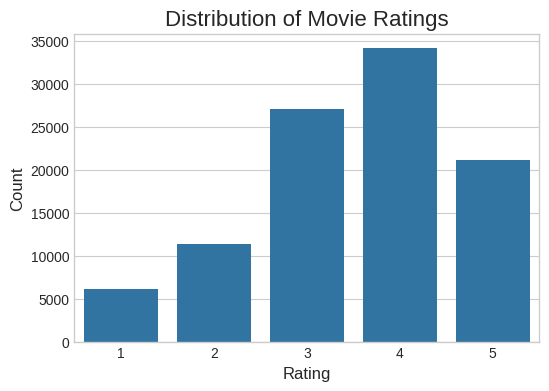

/tmp/ipython-input-2569321741.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=movie_counts.values, y=movie_counts.index, palette='viridis')


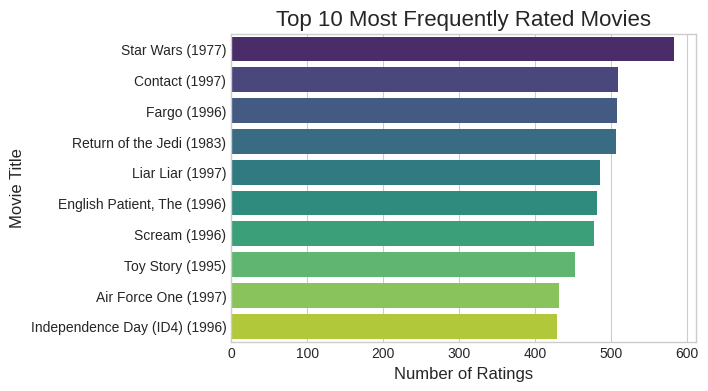


--- Movie Recommendation System Demo ---
Welcome to the Movie Recommendation System!
Please choose a recommendation method:

Choose a recommendation method:
1. User-Based Collaborative Filtering
2. Item-Based Collaborative Filtering
3. Exit the modelEnter your choice (1 or 2 or 3): 1

Enter a user ID to get recommendations: 22
DEBUG: You entered -> '22'

--- User-Based Recommendations for User 22 ---
                                movie title  predicted_score
movie_id                                                    
82                     Jurassic Park (1993)         3.903391
204               Back to the Future (1985)         3.880970
183                            Alien (1979)         3.634421
22                        Braveheart (1995)         3.482916
121           Independence Day (ID4) (1996)         3.243710
64         Shawshank Redemption, The (1994)         2.498988
234                             Jaws (1975)         2.455041
423       E.T. the Extra-Terrestrial (1982)   

In [56]:
def main():
    """
    Main function to run the recommendation system demo and evaluation.
    """
    visualize_data()

    print("\n--- Movie Recommendation System Demo ---")
    print("Welcome to the Movie Recommendation System!")
    print("Please choose a recommendation method:")

    method_choice = ""
    while(method_choice != "3"):

      try:

        # Step 1: Select recommendation approach
        method_choice = input(
               "\nChoose a recommendation method:\n"
                "1. User-Based Collaborative Filtering\n"
                "2. Item-Based Collaborative Filtering\n"
                "3. Exit the model"
                "Enter your choice (1 or 2 or 3): "
            ).strip()

        # Step 2: Request user ID for recommendations
        if method_choice == "1":
          raw_input_val = input("\nEnter a user ID to get recommendations: ").strip()
          print(f"DEBUG: You entered -> '{raw_input_val}'")  # Debug line
          target_user = int(raw_input_val)

          print(f"\n--- User-Based Recommendations for User {target_user} ---")
          recs = recommend_movies_user_based(target_user, top_n=10, k_neighbors=5)
          if not recs.empty:
            print(recs)

          print("\n--- Evaluating User-Based Precision@10 ---")
          precision = precision_at_k_user_based(k=10)
          print(f"Precision@10: {precision:.4f}")

        elif method_choice == "2":
            raw_input_val = input("\nEnter a user ID to get recommendations: ").strip()
            print(f"DEBUG: You entered -> '{raw_input_val}'")  # Debug line
            target_user = int(raw_input_val)

            print(f"\n--- Item-Based Recommendations for User {target_user} ---")
            recs = recommend_movies_item_based(target_user, top_n=10)
            if not recs.empty:
              print(recs)

            print("\n--- Evaluating Item-Based Precision@10 ---")
            precision = precision_at_k_item_based(k=10)
            print(f"Precision@10: {precision:.4f}")

        elif method_choice=="3":

          print("\n Exiting the model. Goodbye!")
          break
        else:
          print("Invalid choice. Please enter 1 or 2.")

      except ValueError:
        print("Invalid input. Please enter a valid integer user ID.")
      except Exception as e:
        print(f"An error occurred: {e}")


# ============================================================
# 14. Entry Point
# ============================================================
if __name__ == "__main__":
    main()
